In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import re

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denisshpilka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denisshpilka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_path = os.path.join('data', 'train.csv')

In [4]:
df = pd.read_csv(train_path)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## EDA

In [5]:
# Check for missing values
print('# of missing values in the dataset:')
print(df.isnull().sum())

# of missing values in the dataset:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


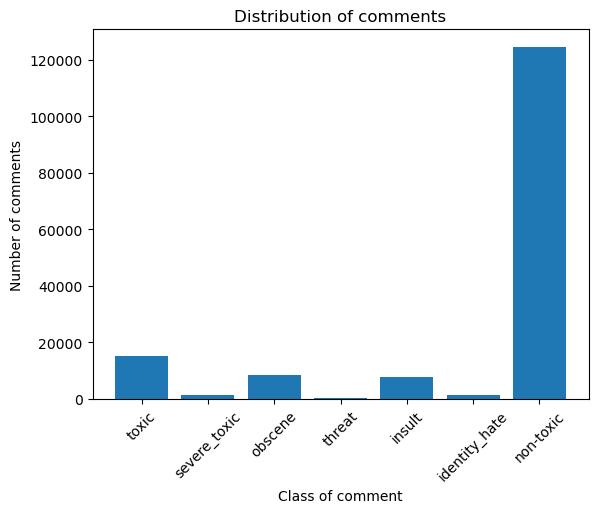

In [6]:
# Visualise the number of toxic/non-toxic comments
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

x = df[target_columns].sum(axis = 0)
non_toxic = pd.Series([df.shape[0] - x.sum()], index = ['non-toxic'])
x = pd.concat([x, non_toxic])


plt.bar(x.index, x.values)
plt.title('Distribution of comments')
plt.xlabel('Class of comment')
plt.ylabel('Number of comments')
plt.xticks(rotation = 45)
plt.show()

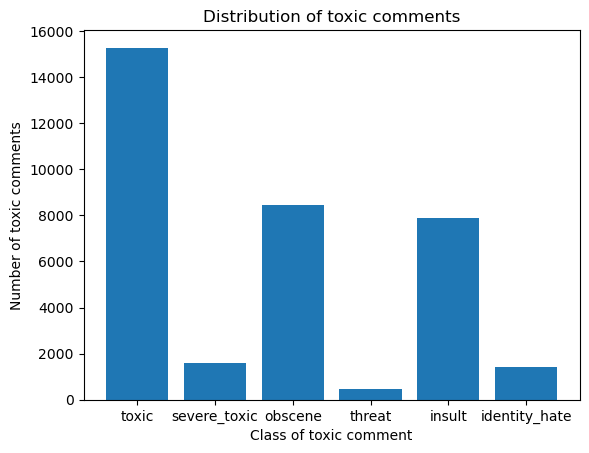

In [7]:
# Visualise the number of toxic/non-toxic comments
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

x = df[target_columns].sum(axis = 0)

plt.bar(x.index, x.values)
plt.title('Distribution of toxic comments')
plt.xlabel('Class of toxic comment')
plt.ylabel('Number of toxic comments')
plt.show()

In [8]:
df['is_toxic'] = df[target_columns].sum(axis = 1)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [9]:
df['is_toxic'].value_counts(normalize=True)

is_toxic
0    0.898321
1    0.039857
3    0.026377
2    0.021808
4    0.011030
5    0.002413
6    0.000194
Name: proportion, dtype: float64

In [10]:
for x, y in x.items():
    print(x, y)

toxic 15294
severe_toxic 1595
obscene 8449
threat 478
insult 7877
identity_hate 1405


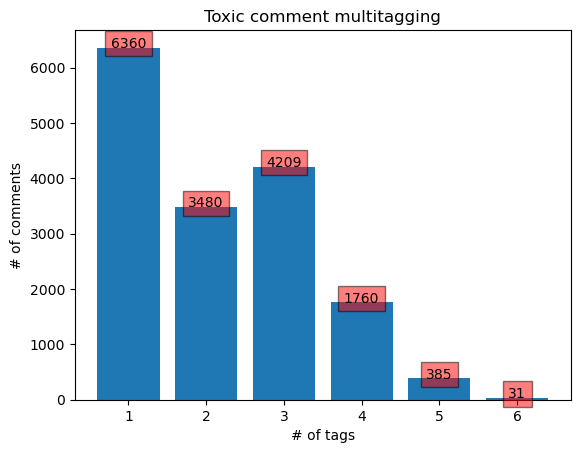

In [11]:
x = df.query('is_toxic > 0')['is_toxic'].value_counts()

plt.bar(x.index, x.values)
for x, y in x.items():
    plt.text(x, y, y, ha = 'center', bbox = dict(facecolor = 'red', alpha = 0.5))

plt.title('Toxic comment multitagging')
plt.xlabel('# of tags')
plt.ylabel('# of comments')
plt.show()

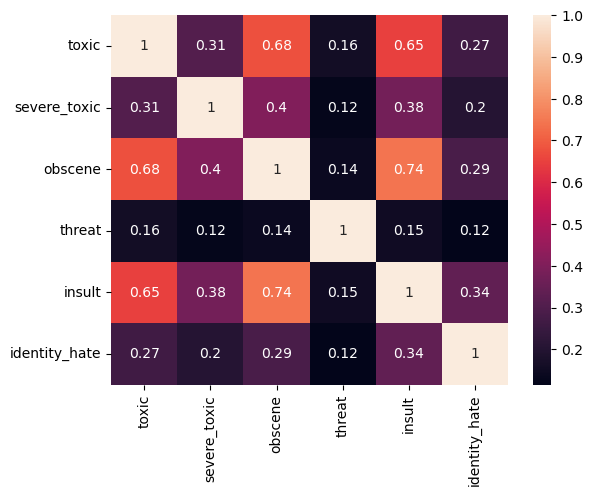

In [21]:
corr_mat = df[target_columns].corr()

sns.heatmap(corr_mat, annot=True)
plt.show()

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    words = text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    processed_text = ' '.join(processed_words)
    return processed_text

In [10]:
df['comment_text'] = df['comment_text'].apply(preprocess_text)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seemingly stuc...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second time asking view completely contradicts...,0,0,0,0,0,0,0
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there actual article prostitution ...,0,0,0,0,0,0,0
159569,fff125370e4aaaf3,look like actually put speedy first version de...,0,0,0,0,0,0,0


In [19]:
tokens_list = []

for text in df['comment_text']:
    tokens_list.extend(text.split(' '))

len(set(tokens_list))

212559

In [53]:
word_freqs_df = pd.DataFrame(index=list(set(tokens_list)), columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']).fillna(0)
word_freqs_df

C:\Users\denis\AppData\Local\Temp\ipykernel_19996\328508825.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  word_freqs_df = pd.DataFrame(index=list(set(tokens_list)), columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']).fillna(0)


,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
,0,0,0,0,0,0,0
dagnabbit,0,0,0,0,0,0,0
httpwwwedgovrschstatresearchpubsmisconductreviewreportpdf,0,0,0,0,0,0,0
duncharris,0,0,0,0,0,0,0
glycerol,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
aboutthe,0,0,0,0,0,0,0
thougharound,0,0,0,0,0,0,0
mien,0,0,0,0,0,0,0
katzenbach,0,0,0,0,0,0,0


In [55]:
word_freqs_df.loc['mien']

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non_toxic        0
Name: mien, dtype: int64

In [61]:
for index, row in df.iterrows():
    toxicity_type = row[target_columns].index[row[target_columns] > 0]
    if len(toxicity_type) == 0: continue

    for word in row['comment_text'].split(' '):
        word_freqs_df.loc[word, toxicity_type] += 1

In [68]:
word_freqs_df['total_sum'] = word_freqs_df[target_columns].sum(axis = 1)
word_freqs_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_sum
,0,0,0,0,0,0,0,0
dagnabbit,0,0,0,0,0,0,0,0
httpwwwedgovrschstatresearchpubsmisconductreviewreportpdf,0,0,0,0,0,0,0,0
duncharris,1,0,1,0,1,1,0,4
glycerol,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
aboutthe,0,0,0,0,0,0,0,0
thougharound,0,0,0,0,0,0,0,0
mien,0,0,0,0,0,0,0,0
katzenbach,0,0,0,0,0,0,0,0


In [69]:
word_freqs_df.sort_values('total_sum', reversed = True)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_sum
meanman,0,0,0,0,0,0,0,0
pulsar,0,0,0,0,0,0,0,0
shefas,0,0,0,0,0,0,0,0
techincal,0,0,0,0,0,0,0,0
katchi,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
shit,3606,1881,3201,70,1682,410,0,10850
fucking,3203,1375,3107,136,2719,519,0,11059
nigger,3418,1017,2833,10,2884,3082,0,13244
suck,4477,3302,3890,14,3549,505,0,15737
